In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn
import sklearn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split

plt.style.use("../science.mplstyle")

# Pre-training

In [2]:
def plot_wirelines(df1, df2=None, label1=None, label2=None):
    fig, ax = plt.subplots(figsize=(15,8))#Set up the plot axes
    ax1 = plt.subplot2grid((1,7), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,7), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,7), (0,2), rowspan=1, colspan = 1, sharey = ax1)
    ax4 = plt.subplot2grid((1,7), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = ax3.twiny() 
    ax7 = plt.subplot2grid((1,7), (0,5), rowspan=1, colspan = 1, sharey = ax1)
    # ax8 = plt.subplot2grid((1,7), (0,6), rowspan=1, colspan = 1, sharey = ax1)

    #Twins the y-axis for the density track with the neutron track
    ax6 = plt.subplot2grid((1,7), (0,4), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax6.twiny()
    ax14.xaxis.set_visible(False)
    ax15 = ax7.twiny()
    ax15.xaxis.set_visible(False)
    # ax16 = ax8.twiny()
    # ax16.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPTH_MD", data=df1, color = "green", lw = 1.5, label=label1)
    ax1.set_xlabel("Gamma Ray [API]")
    ax1.xaxis.label.set_color("green")
    # ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    if (df2 != None).all().values[0]:
        ax1.plot("GR", "DEPTH_MD", data=df2, color = "black", lw = 1.5, label=label2)
        ax1.legend()
    # ax1.set_xticks([0, 50, 100, 150, 200])

    # Resistivity track
    ax2.plot("RDEP", "DEPTH_MD", data=df1, color = "red", lw = 1.5, label=label1)
    ax2.set_xlabel("Resistivity - Deep [ohm.m]")
    # ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    # ax2.set_xticks([0.1, 1, 10, 100, 1000])
    # ax2.semilogx()
    if (df2 != None).all().values[0]:
        ax2.plot("RDEP", "DEPTH_MD", data=df1, color = "black", lw = 1.5, label=label2)
        ax2.legend()

    # Density track
    ax3.plot("RHOB", "DEPTH_MD", data=df1, color = "red", lw = 1.5, label=label1)
    ax3.set_xlabel("Density [g/cc]")
    # ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("red")
    ax3.tick_params(axis='x', colors="red")
    ax3.spines["top"].set_edgecolor("red")
    if (df2 != None).all().values[0]:
        ax3.plot("RHOB", "DEPTH_MD", data=df1, color = "black", lw = 1.5, label=label2)
    # ax3.set_xticks([1.95, 2.45, 2.95])

    # Sonic track
    ax4.plot("DTC", "DEPTH_MD", data=df1, color = "purple", lw = 1.5, label=label1)
    ax4.set_xlabel("Sonic - Compressional [us/ft]")
    # ax4.set_xlim(140, 40)
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")
    if (df2 != None).all().values[0]:
        ax4.plot("DTC", "DEPTH_MD", data=df1, color = "black", lw = 1.5, label=label2)
        ax4.legend()

    # Neutron track placed ontop of density track
    ax5.plot("NPHI", "DEPTH_MD", data=df1, color = "blue", lw = 1.5, label=label1)
    ax5.set_xlabel('Neutron [pu]')
    ax5.xaxis.label.set_color("blue")
    # ax5.set_xlim(.5, 0)
    ax5.tick_params(axis='x', colors="blue")
    ax5.spines["top"].set_position(("axes", 1.1))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("blue")
    if (df2 != None).all().values[0]:
        ax5.plot("NPHI", "DEPTH_MD", data=df1, color = "black", lw = 1.5, label=label2)
        ax5.legend()        
    # ax5.set_xticks([45,  15, -15])

    # Caliper track
    ax6.plot("CALI", "DEPTH_MD", data=df1, color = "orange", lw = 1.5, label=label1)
    ax6.set_xlabel("Caliper [inch]")
    # ax6.set_xlim(8, 10)
    ax6.xaxis.label.set_color("orange")
    ax6.tick_params(axis='x', colors="orange")
    ax6.spines["top"].set_edgecolor("orange")
    if (df2 != None).all().values[0]:
        ax6.plot("CALI", "DEPTH_MD", data=df1, color = "black", lw = 1.5, label=label2)
        ax6.legend()
    # ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
    # ax6.set_xticks([6,  11, 16])

    # Shear track
    ax7.plot("PEF", "DEPTH_MD", data=df1, color = "magenta", lw = 1.5, label=label1)
    ax7.set_xlabel("Photoelectric [API]")
    # ax4.set_xlim(140, 40)
    ax7.xaxis.label.set_color("purple")
    ax7.tick_params(axis='x', colors="magenta")
    ax7.spines["top"].set_edgecolor("magenta")
    if (df2 != None).all().values[0]:
        ax7.plot("PEF", "DEPTH_MD", data=df1, color = "black", lw = 1.5, label=label2)
        ax7.legend()

    # # Shear track
    # ax4.plot("DTC", "DEPTH_MD", data=df1, color = "purple", lw = 1.5, label=label1)
    # ax4.set_xlabel("Sonic - Compressional [us/ft]")
    # # ax4.set_xlim(140, 40)
    # ax4.xaxis.label.set_color("purple")
    # ax4.tick_params(axis='x', colors="purple")
    # ax4.spines["top"].set_edgecolor("purple")
    # if (df2 != None).all().values[0]:
    #     ax4.plot("DTC", "DEPTH_MD", data=df1, color = "black", lw = 1.5, label=label2)
    #     ax4.legend()

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4, ax6, ax7]:
        # ax.set_ylim(4500, 3500)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3, ax4, ax6, ax7]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    plt.show()

# Wrap in PyTorch dataset
class WirelineDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len, pred_type='DTS'):
        self.data = data
        self.seq_len = seq_len
        self.pred_type = pred_type
    def __getitem__(self, idx):

        well = np.unique(self.data.WELL.values[idx*self.seq_len:(idx+1)*self.seq_len])[0]
        if self.pred_type=='DTS':
            data = self.data.drop(columns=['DTS','Type']).values[idx*self.seq_len:(idx+1)*self.seq_len]
            label = self.data['DTS'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)
        elif self.pred_type=='FACIES':
            data = self.data.drop(columns=['FORCE_2020_LITHOFACIES_LITHOLOGY']).values[idx*self.seq_len:(idx+1)*self.seq_len]
            label = self.data['FORCE_2020_LITHOFACIES_LITHOLOGY'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)

        wells = {'well': well, 'data': data, 'label':label}

        return wells
    def __len__(self):
        return int(len(self.data)/self.seq_len)

def plot_wirelines_dts(df1, df2=None, label1=None, label2=None):
    fig, ax = plt.subplots(figsize=(15,8))#Set up the plot axes
    ax1 = plt.subplot2grid((1,8), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,8), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,8), (0,2), rowspan=1, colspan = 1, sharey = ax1)
    ax4 = plt.subplot2grid((1,8), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = ax3.twiny() 
    ax7 = plt.subplot2grid((1,8), (0,5), rowspan=1, colspan = 1, sharey = ax1)
    ax8 = plt.subplot2grid((1,8), (0,6), rowspan=1, colspan = 1, sharey = ax1)

    #Twins the y-axis for the density track with the neutron track
    ax6 = plt.subplot2grid((1,8), (0,4), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax6.twiny()
    ax14.xaxis.set_visible(False)
    ax15 = ax7.twiny()
    ax15.xaxis.set_visible(False)
    ax16 = ax8.twiny()
    ax16.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPTH_MD", data=df1, color = "green", lw = 1.5, label=label1)
    ax1.set_xlabel("Gamma Ray [API]")
    ax1.xaxis.label.set_color("green")
    # ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    # ax1.set_xticks([0, 50, 100, 150, 200])

    # Resistivity track
    ax2.plot("RDEP", "DEPTH_MD", data=df1, color = "red", lw = 1.5, label=label1)
    ax2.set_xlabel("Resistivity - Deep [ohm.m]")
    # ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    # ax2.set_xticks([0.1, 1, 10, 100, 1000])
    # ax2.semilogx()

    # Density track
    ax3.plot("RHOB", "DEPTH_MD", data=df1, color = "red", lw = 1.5, label=label1)
    ax3.set_xlabel("Density [g/cc]")
    # ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("red")
    ax3.tick_params(axis='x', colors="red")
    ax3.spines["top"].set_edgecolor("red")
    # ax3.set_xticks([1.95, 2.45, 2.95])

    # Sonic track
    ax4.plot("DTC", "DEPTH_MD", data=df1, color = "purple", lw = 1.5, label=label1)
    ax4.set_xlabel("Sonic - Compressional [us/ft]")
    # ax4.set_xlim(140, 40)
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")

    # Neutron track placed ontop of density track
    ax5.plot("NPHI", "DEPTH_MD", data=df1, color = "blue", lw = 1.5, label=label1)
    ax5.set_xlabel('Neutron [pu]')
    ax5.xaxis.label.set_color("blue")
    # ax5.set_xlim(.5, 0)
    ax5.tick_params(axis='x', colors="blue")
    ax5.spines["top"].set_position(("axes", 1.1))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("blue")   
    # ax5.set_xticks([45,  15, -15])

    # Caliper track
    ax6.plot("CALI", "DEPTH_MD", data=df1, color = "orange", lw = 1.5, label=label1)
    ax6.set_xlabel("Caliper [inch]")
    # ax6.set_xlim(8, 10)
    ax6.xaxis.label.set_color("orange")
    ax6.tick_params(axis='x', colors="orange")
    ax6.spines["top"].set_edgecolor("orange")
    # ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
    # ax6.set_xticks([6,  11, 16])

    # Shear track
    ax7.plot("PEF", "DEPTH_MD", data=df1, color = "magenta", lw = 1.5, label=label1)
    ax7.set_xlabel("Photoelectric [API]")
    # ax4.set_xlim(140, 40)
    ax7.xaxis.label.set_color("purple")
    ax7.tick_params(axis='x', colors="magenta")
    ax7.spines["top"].set_edgecolor("magenta")

    # Shear track
    ax8.plot("DTS", "DEPTH_MD", data=df1, color = "purple", lw = 1.5, label=label1)
    ax8.set_xlabel("Sonic - Shear [us/ft]")
    # ax4.set_xlim(140, 40)
    ax8.xaxis.label.set_color("purple")
    ax8.tick_params(axis='x', colors="purple")
    ax8.spines["top"].set_edgecolor("purple")
    if (df2 != None).all().values[0]:
        ax8.plot("DTS", "DEPTH_MD", data=df2, color = "orange", lw = 1.5, label=label2)
        ax8.legend()

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4, ax6, ax7, ax8]:
        # ax.set_ylim(4500, 3500)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3, ax4, ax6, ax7, ax8]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    plt.show()

def plot_wirelines_facies(df1, df2=None, label1=None, label2=None):
    fig, ax = plt.subplots(figsize=(15,8))#Set up the plot axes
    ax1 = plt.subplot2grid((1,8), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,8), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,8), (0,2), rowspan=1, colspan = 1, sharey = ax1)
    ax4 = plt.subplot2grid((1,8), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = ax3.twiny() 
    ax7 = plt.subplot2grid((1,8), (0,5), rowspan=1, colspan = 1, sharey = ax1)
    ax8 = plt.subplot2grid((1,8), (0,6), rowspan=1, colspan = 1, sharey = ax1)
    ax9 = plt.subplot2grid((1,8), (0,7), rowspan=1, colspan = 1, sharey = ax1)

    #Twins the y-axis for the density track with the neutron track
    ax6 = plt.subplot2grid((1,8), (0,4), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax6.twiny()
    ax14.xaxis.set_visible(False)
    ax15 = ax7.twiny()
    ax15.xaxis.set_visible(False)
    ax16 = ax8.twiny()
    ax16.xaxis.set_visible(False)
    ax17 = ax9.twiny()
    ax17.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPTH_MD", data=df1, color = "green", lw = 1.5, label=label1)
    ax1.set_xlabel("Gamma Ray [API]")
    ax1.xaxis.label.set_color("green")
    # ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    # ax1.set_xticks([0, 50, 100, 150, 200])

    # Resistivity track
    ax2.plot("RDEP", "DEPTH_MD", data=df1, color = "red", lw = 1.5, label=label1)
    ax2.set_xlabel("Resistivity - Deep [ohm.m]")
    # ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    # ax2.set_xticks([0.1, 1, 10, 100, 1000])
    # ax2.semilogx()

    # Density track
    ax3.plot("RHOB", "DEPTH_MD", data=df1, color = "red", lw = 1.5, label=label1)
    ax3.set_xlabel("Density [g/cc]")
    # ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("red")
    ax3.tick_params(axis='x', colors="red")
    ax3.spines["top"].set_edgecolor("red")
    # ax3.set_xticks([1.95, 2.45, 2.95])

    # Sonic track
    ax4.plot("DTC", "DEPTH_MD", data=df1, color = "purple", lw = 1.5, label=label1)
    ax4.set_xlabel("Sonic - Compressional [us/ft]")
    # ax4.set_xlim(140, 40)
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")

    # Neutron track placed ontop of density track
    ax5.plot("NPHI", "DEPTH_MD", data=df1, color = "blue", lw = 1.5, label=label1)
    ax5.set_xlabel('Neutron [pu]')
    ax5.xaxis.label.set_color("blue")
    # ax5.set_xlim(.5, 0)
    ax5.tick_params(axis='x', colors="blue")
    ax5.spines["top"].set_position(("axes", 1.1))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("blue")   
    # ax5.set_xticks([45,  15, -15])

    # Caliper track
    ax6.plot("CALI", "DEPTH_MD", data=df1, color = "orange", lw = 1.5, label=label1)
    ax6.set_xlabel("Caliper [inch]")
    # ax6.set_xlim(8, 10)
    ax6.xaxis.label.set_color("orange")
    ax6.tick_params(axis='x', colors="orange")
    ax6.spines["top"].set_edgecolor("orange")
    # ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
    # ax6.set_xticks([6,  11, 16])

    # Shear track
    ax7.plot("PEF", "DEPTH_MD", data=df1, color = "magenta", lw = 1.5, label=label1)
    ax7.set_xlabel("Photoelectric [API]")
    # ax4.set_xlim(140, 40)
    ax7.xaxis.label.set_color("purple")
    ax7.tick_params(axis='x', colors="magenta")
    ax7.spines["top"].set_edgecolor("magenta")

    # Lithology track
    ax8.plot("FACIES", 'DEPTH_MD', data=df1, color = "black", lw = 1.5)
    ax8.set_xlabel("Lithology")
    ax8.set_xlim(0, 1)
    ax8.xaxis.label.set_color("black")
    ax8.tick_params(axis='x', colors="black")
    ax8.spines["top"].set_edgecolor("black")

    # Lithology track
    ax9.plot("FACIES", 'DEPTH_MD', data=df2, color = "black", lw = 1.5)
    ax9.set_xlabel("Lithology")
    ax9.set_xlim(0, 1)
    ax9.xaxis.label.set_color("black")
    ax9.tick_params(axis='x', colors="black")
    ax9.spines["top"].set_edgecolor("black")

    for key in lithology_numbers.keys():
        color = lithology_numbers[key]['color']
        # hatch = lithology_numbers[key]['hatch']
        ax8.fill_betweenx(df1['DEPTH_MD'], 0, df1['FACIES'], where=(df1['FACIES']==key), facecolor=color)

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4, ax6, ax7, ax8, ax9]:
        # ax.set_ylim(4500, 3500)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3, ax4, ax6, ax7, ax8, ax9]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    plt.show()

# Wrap in PyTorch dataset
class WirelineDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len, pred_type='DTS'):
        self.data = data
        self.seq_len = seq_len
        self.pred_type = pred_type
    def __getitem__(self, idx):

        well = np.unique(self.data.WELL.values[idx*self.seq_len:(idx+1)*self.seq_len])[0]
        if self.pred_type=='DTS':
            data = self.data.drop(columns=['DTS','Type']).values[idx*self.seq_len:(idx+1)*self.seq_len]
            label = self.data['DTS'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)
        elif self.pred_type=='FACIES':
            data = self.data.drop(columns=['FORCE_2020_LITHOFACIES_LITHOLOGY']).values[idx*self.seq_len:(idx+1)*self.seq_len]
            label = self.data['FORCE_2020_LITHOFACIES_LITHOLOGY'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)

        wells = {'well': well, 'data': data, 'label':label}

        return wells
    def __len__(self):
        return int(len(self.data)/self.seq_len)

# DTS

In [3]:
# Load the training data
train_data = pd.read_csv('../../../labs/data/train.csv', sep=';')
train_data['WELL'] = train_data['WELL'].astype('category').cat.codes

# Load the validing data
valid_data = pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')
valid_data['WELL'] = valid_data['WELL'].astype('category').cat.codes

train_data = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()
valid_data = valid_data[~np.isnan(valid_data.DTS.values)][['WELL', 'DEPTH_MD','CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()

train_data['RDEP']=np.log(train_data.RDEP.values)
valid_data['RDEP']=np.log(valid_data.RDEP.values)

train_data['Type'] = 'Training'
valid_data['Type'] = 'Validation'

# sns.pairplot(train_data.append(valid_data).sample(1024 , axis=0), hue='Type')

train_data = train_data.mask(train_data>train_data.quantile(0.95), train_data.quantile(0.95), axis=1)
valid_data = valid_data.mask(valid_data>valid_data.quantile(0.95), valid_data.quantile(0.95), axis=1)

# sns.pairplot(train_data.append(valid_data).sample(1024 , axis=0), hue='Type')

transform = sklearn.preprocessing.MinMaxScaler()
df = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

transform = sklearn.preprocessing.MinMaxScaler()
df = valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

# Select input
X_train = train_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_train = train_data[['DTS', 'WELL']].copy()

X_valid = valid_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_valid = valid_data[['DTS', 'WELL']].copy()

# Define Train Set
X_train = torch.from_numpy(X_train.to_numpy()).float().view(-1,X_train.shape[1])
y_train = torch.from_numpy(y_train.to_numpy()).float().view(-1,y_train.shape[1])
train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_valid = torch.from_numpy(X_valid.to_numpy()).float().view(-1,X_valid.shape[1])
y_valid = torch.from_numpy(y_valid.to_numpy()).float().view(-1,y_valid.shape[1])
valid_dataset = TensorDataset(X_valid, y_valid)

# Naive way to segment the wireline data based on specific sequence length
seq_len = 512
df_train = train_data[train_data['WELL']==7][:seq_len]
for i in np.unique(train_data.WELL.values):
    sz = len(train_data[train_data['WELL']==i])//seq_len
    for j in range(sz):
        df_train_seq = train_data[train_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_train = df_train.append(df_train_seq, ignore_index=True)
    
    df_train = df_train.append(train_data[train_data['WELL']==i][-seq_len:], ignore_index=True)

df_valid = valid_data[valid_data['WELL']==1][:seq_len]
for i in np.unique(valid_data.WELL.values):
    sz = len(valid_data[valid_data['WELL']==i])//seq_len
    for j in range(sz):
        df_valid_seq = valid_data[valid_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_valid = df_valid.append(df_valid_seq, ignore_index=True)
    
    df_valid = df_valid.append(valid_data[valid_data['WELL']==i][-seq_len:], ignore_index=True)

# Removing less than sequence length well
for i in np.unique(train_data.WELL.values):
    if len(df_train[df_train.WELL==i])%seq_len!=0:
        print(i, len(train_data[train_data.WELL==55]))
        df_train = df_train.drop(df_train[df_train.WELL==i].index)

# Dataset
train_dataset = WirelineDataset(df_train, 256, pred_type='DTS')
valid_dataset = WirelineDataset(df_valid, 256, pred_type='DTS')

# train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=X_valid.size(0), shuffle=False)

0.5714285714285714 0


# FACIES

In [3]:
traindata = pd.read_csv('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/train.csv', sep=';')
validdata = pd.read_csv('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/leaderboard_test_features.csv', sep=';')

traindata_logavailability = 100 - (traindata.isna().sum()/traindata.shape[0])[2:-2] * 100
validdata_logavailability = 100 - (validdata.isna().sum()/validdata.shape[0])[2:] * 100

trainwellnames = traindata['WELL'].unique()

def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    return X_aug

def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug

def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

def add_suffix(elements, string):
    return [el + string for el in elements]

nlithofacies = 12
lithofacies_names = {
    30000: 'Sandstone',
    65030: 'SS/Shale',
    65000: 'Shale',
    80000: 'Dolomite',
    74000: 'Tuff',
    70000: 'Marl',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Coal', 
    99000: 'Limestone',
    90000: 'Anhydrite', 
    93000: 'Basement'
}
lithofacies_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}
lithofacies_colors =  {
    30000: 'y',
    65030: '#96c136',
    65000: 'g',
    80000: '#5f5f5f',
    74000: 'k',
    70000: 'r',
    70032: '#e5E5E5',
    88000: 'c',
    86000: 'b',
    99000: 'm',
    90000: '#fe9300',
    93000: '#895347'
}

trainlabels = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_names).value_counts()

traindata.select_dtypes(include=np.number)

welldata = traindata[traindata['WELL'] == trainwellnames[1]]

las = lasio.LASFile()
numerical_columns = traindata.select_dtypes(include=np.number).columns
for log in numerical_columns:
    las.add_curve(log, welldata[log].values)

numerical_columns = traindata.select_dtypes(include=np.number).columns

dropped_cols = ['RSHA', 'SGR', 'DCAL', 'MUDWEIGHT', 'RMIC', 'RXO']

traindata = traindata.drop(dropped_cols, axis=1)
validdata = validdata.drop(dropped_cols, axis=1)

trainwellcodes = dict(zip(traindata['WELL'].astype('category').cat.codes, traindata['WELL'] ) )
trainwellcodes1 = dict((v,k) for k,v in trainwellcodes.items())

traindata['GROUP'] = traindata['GROUP'].astype('category').cat.codes 
traindata['FORMATION'] = traindata['FORMATION'].astype('category').cat.codes
traindata['WELL'] = traindata['WELL'].astype('category').cat.codes

validdata['GROUP'] = validdata['GROUP'].astype('category').cat.codes 
validdata['FORMATION'] = validdata['FORMATION'].astype('category').cat.codes
validdata['WELL'] = validdata['WELL'].astype('category').cat.codes

traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'] = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithofacies_numbers)

# Impute missing values 
traindata = traindata.fillna(method='pad')
validdata = validdata.fillna(method='pad')

traindata = traindata.fillna(method='backfill')
validdata = validdata.fillna(method='backfill')

A=np.load('/home/taufikmh/KAUST/spring_2022/erse_222_machine_learning_in_geoscience/labs/data/penalty_matrix.npy')

# Choose which features to augument 
aug_labels = list(traindata.columns)
aug_labels.remove('WELL')
aug_labels.remove('FORCE_2020_LITHOFACIES_LITHOLOGY')
aug_labels.remove('FORCE_2020_LITHOFACIES_CONFIDENCE')
aug_traindata = augment_features(traindata.loc[:, aug_labels].values, traindata['WELL'], traindata['DEPTH_MD'])
aug_validdata = augment_features(validdata.loc[:, aug_labels].values, validdata['WELL'], validdata['DEPTH_MD'])
aug_newlabels = add_suffix(aug_labels, '_AVE1') + add_suffix(aug_labels, '_AVE2') + add_suffix(aug_labels, '_AVE3') + add_suffix(aug_labels, '_DIFF')

aug_traindata = pd.DataFrame(aug_traindata, columns=aug_newlabels)
aug_validdata = pd.DataFrame(aug_traindata, columns=aug_newlabels)

random.seed(15)
validnwells = 10
validwellnames = random.sample(list(trainwellnames), validnwells)
validwelllabels = [trainwellcodes1[wellname] for wellname in validwellnames]
validnwellcodes = dict((v,k) for k,v in zip(validwellnames, validwelllabels))
validnwellcodes1 = dict((v,k) for k,v in validnwellcodes.items()) # swap keys and values

validdata = traindata[traindata['WELL'].isin(validwelllabels)].reset_index(drop=True)
traindata = traindata[~traindata['WELL'].isin(validwelllabels)].reset_index(drop=True)

# trainlitho = traindata['FORCE_2020_LITHOFACIES_LITHOLOGY']
# traindata = traindata.drop('FORCE_2020_LITHOFACIES_LITHOLOGY', axis=1)

train_facies_all = traindata[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].dropna()
valid_facies_all = validdata[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].dropna()

transform = sklearn.preprocessing.MinMaxScaler()
train_data = train_facies_all[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].copy().dropna()
# train_data = train_data.mask(train_data>train_data.quantile(0.95), train_data.quantile(0.95), axis=1)

# df = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']]
# train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

# Unnormalized
df = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

transform = sklearn.preprocessing.MinMaxScaler()
valid_data = valid_facies_all[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']].copy().dropna()
# valid_data = valid_data.mask(valid_data>valid_data.quantile(0.95), valid_data.quantile(0.95), axis=1)

# df = valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']]
# valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

df = valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

df_train = train_data
df_valid = valid_data

# Dataset
train_dataset = WirelineDataset(df_train, seq_len=256, pred_type='FACIES')
valid_dataset = WirelineDataset(df_valid, seq_len=256, pred_type='FACIES')

# Exports

In [ ]:
seq_len = 1024
pred_type = 'DTS'

# Dataset
train_dataset = WirelineDataset(df_train, seq_len, pred_type=pred_type)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

valid_dataset = WirelineDataset(df_valid, seq_len, pred_type=pred_type)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

torch.save(train_dataset, '../data/train_dataset_'+pred_type+'_'+str(seq_len)+'_unnormed.pt')    
torch.save(valid_dataset, '../data/valid_dataset_'+pred_type+'_'+str(seq_len)+'_unnormed.pt')   

torch.save(train_loader, '../data/train_loader_'+pred_type+'_'+str(seq_len)+'_unnormed.pt')
torch.save(valid_loader, '../data/valid_loader_'+pred_type+'_'+str(seq_len)+'_unnormed.pt')

# Validation: Pre-training

In [ ]:
# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']

input_train = np.load('./256_2_8_32_128/pretrain/input_train.npy')
input_valid = np.load('./256_2_8_32_128/pretrain/input_valid.npy')

pred_train = np.load('./256_2_8_32_128/pretrain/pred_train.npy')
pred_valid = np.load('./256_2_8_32_128/pretrain/pred_valid.npy')

mask_train = np.load('./256_2_8_32_128/pretrain/mask_train.npy')
mask_valid = np.load('./256_2_8_32_128/pretrain/mask_valid.npy')

mask_train_df = pd.DataFrame(mask_train.reshape(-1,1), columns=['MASK'])
mask_valid_df = pd.DataFrame(mask_valid.reshape(-1,1), columns=['MASK'])

input_train_df = pd.DataFrame(input_train.reshape(-1,9), columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_train_df = (input_train_df * (1-mask_train_df.values) + mask_train_df.values*-999.25)
input_train_df = input_train_df.replace(-999.25, np.nan)
input_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
input_train_df['WELL'] = train_dataset.data['WELL']

pred_train_df = pd.DataFrame(pred_train.reshape(-1,9), columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
pred_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
pred_train_df['WELL'] = train_dataset.data['WELL']

input_valid_df = pd.DataFrame(input_valid.reshape(-1,9), columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_valid_df = (input_valid_df * (1-mask_valid_df.values) + mask_valid_df.values*-999.25)
input_valid_df = input_valid_df.replace(-999.25, np.nan)
input_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
input_valid_df['WELL'] = valid_dataset.data['WELL']

pred_valid_df = pd.DataFrame(pred_valid.reshape(-1,9), columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
pred_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
pred_valid_df['WELL'] = valid_dataset.data['WELL']

train_well = np.unique(train_dataset.data['WELL'].values)
valid_well = np.unique(valid_dataset.data['WELL'].values)

for i in range(len(train_well)):
        if i % 10 == 0:
                df1 = input_train_df[input_train_df['WELL']==train_well[i]]
                df2 = pred_train_df[pred_train_df['WELL']==train_well[i]]
                plot_wirelines(df1, df2, label1='Input', label2='Prediction')

# plt.plot(input_train_df['DTC'])

# Validation: Fine-tuning

## DTS Prediction

Training


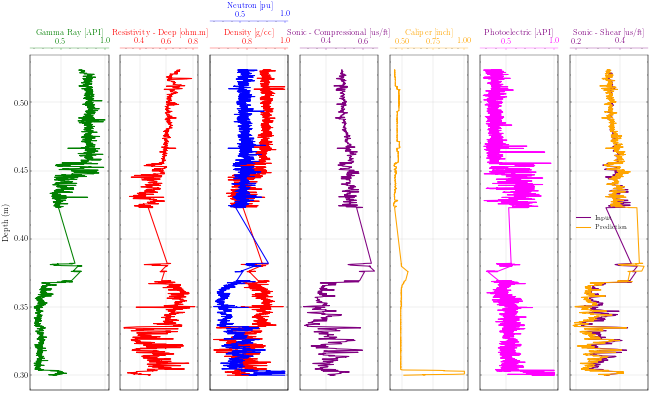

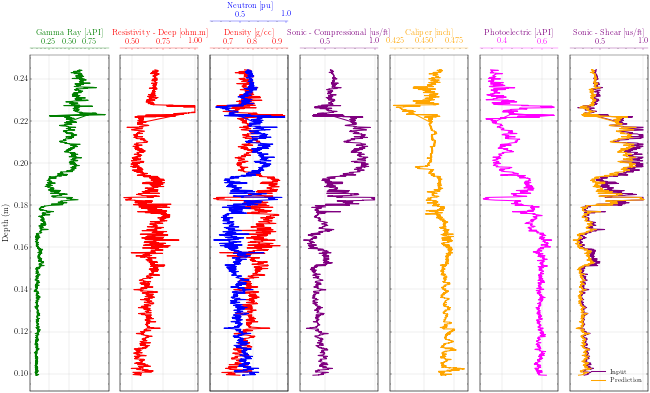

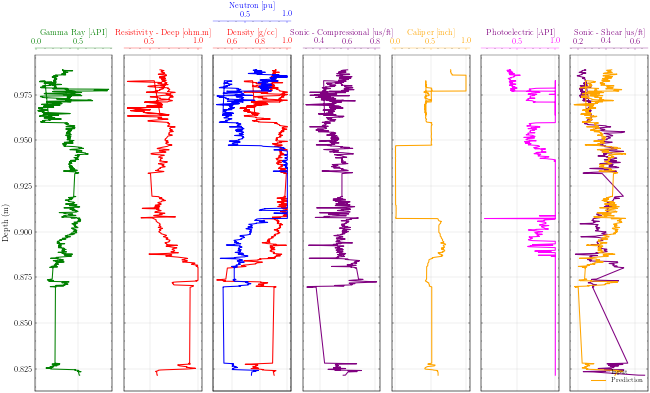

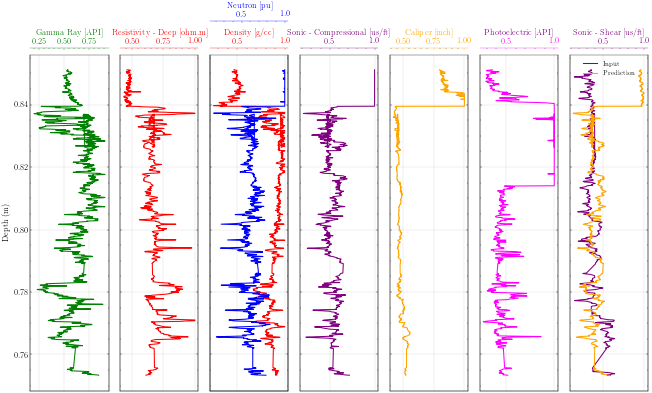

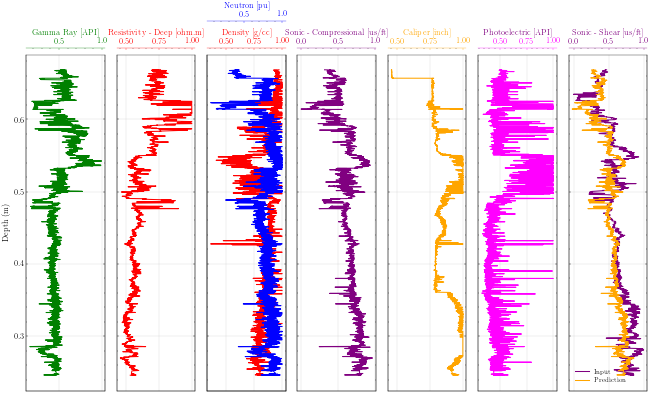

Validation


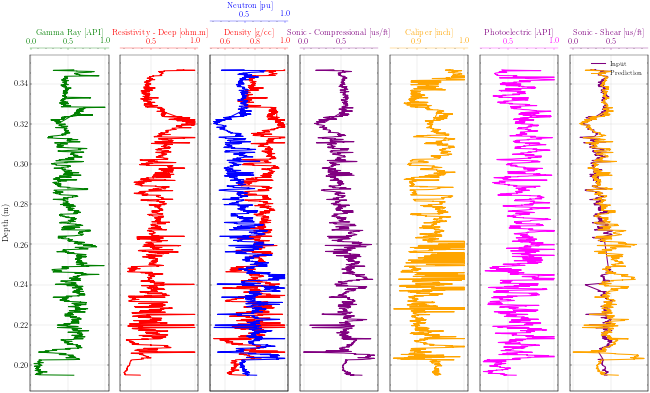

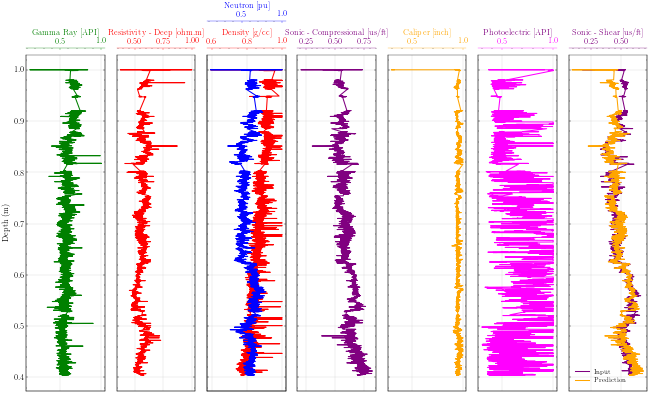

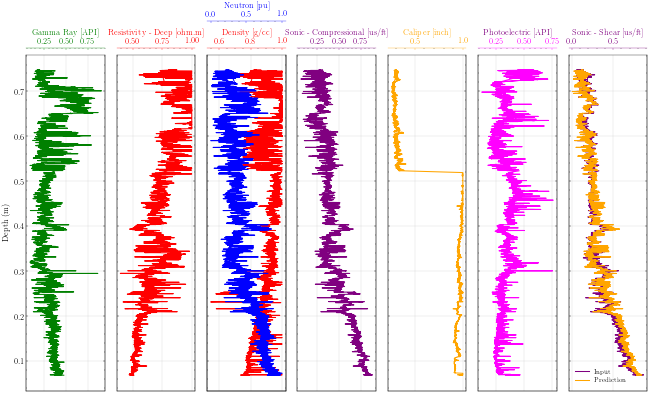

In [4]:
# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']

input_train = np.load('./256_2_8_32_128/finetune/dtspred/input_dts_train.npy')
input_valid = np.load('./256_2_8_32_128/finetune/dtspred/input_dts_valid.npy')

pred_train = np.load('./256_2_8_32_128/finetune/dtspred/pred_dts_train.npy')
pred_valid = np.load('./256_2_8_32_128/finetune/dtspred/pred_dts_valid.npy')

['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']

input_train_df = pd.DataFrame(input_train.reshape(-1,9), columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
input_train_df['WELL'] = train_dataset.data['WELL']
input_train_df['DTS'] = train_dataset.data['DTS']

pred_train_df = pd.DataFrame(pred_train.reshape(-1,1), columns=['DTS'])
pred_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
pred_train_df['WELL'] = train_dataset.data['WELL']

input_valid_df = pd.DataFrame(input_valid.reshape(-1,9), columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
input_valid_df['WELL'] = valid_dataset.data['WELL']
input_valid_df['DTS'] = valid_dataset.data['DTS']

pred_valid_df = pd.DataFrame(pred_valid.reshape(-1,1), columns=['DTS'])
pred_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
pred_valid_df['WELL'] = valid_dataset.data['WELL']

train_well = np.unique(train_dataset.data['WELL'].values)
valid_well = np.unique(valid_dataset.data['WELL'].values)

print('Training')

for i in range(len(train_well)):
        if i % 5 == 0:
                df1 = input_train_df[input_train_df['WELL']==train_well[i]]
                df2 = pred_train_df[pred_train_df['WELL']==train_well[i]]
                plot_wirelines_dts(df1, df2, label1='Input', label2='Prediction')

print('Validation')

for i in range(len(valid_well)):
        if i % 2 == 0:
                df1 = input_valid_df[input_valid_df['WELL']==valid_well[i]]#.head(256)
                df2 = pred_valid_df[pred_valid_df['WELL']==valid_well[i]]#.head(256)
                plot_wirelines_dts(df1, df2, label1='Input', label2='Prediction')

## FACIES Prediction

Training


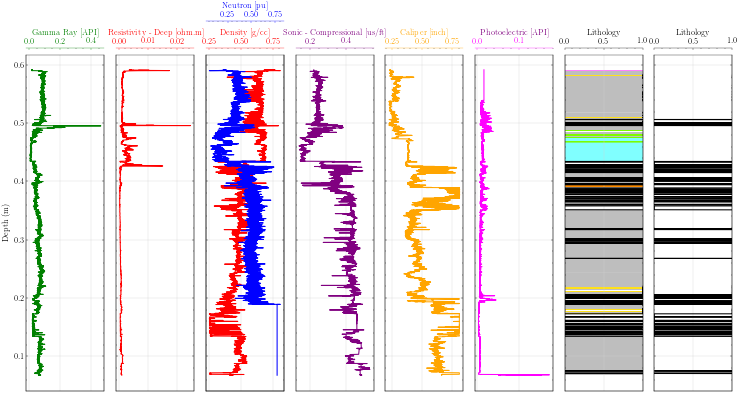

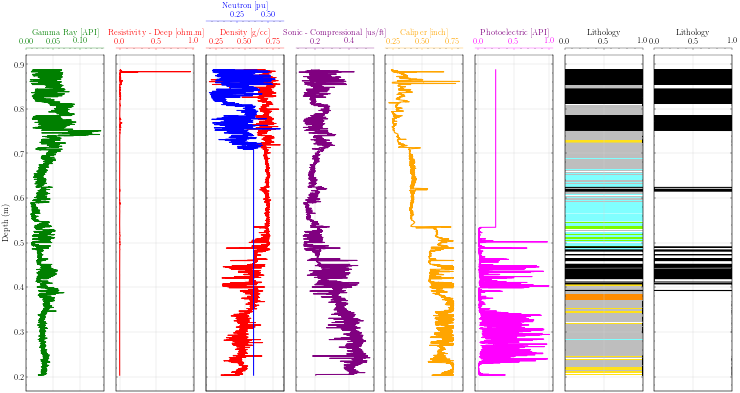

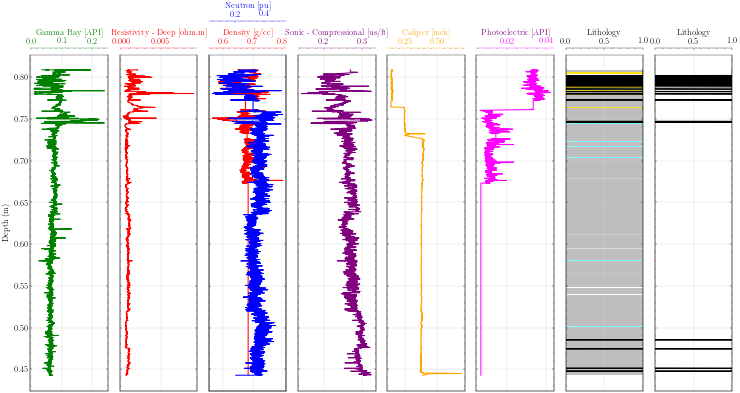

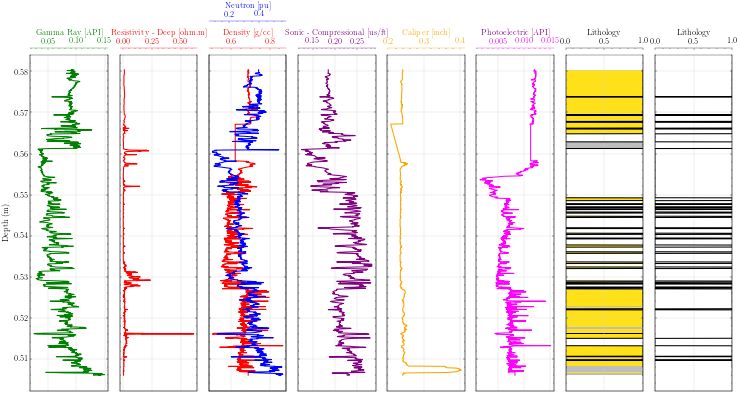

In [40]:
# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'facies', 'DTC']

input_train = np.load('./256_2_8_32_128/finetune/faciespred/input_facies_train.npy')
input_valid = np.load('./256_2_8_32_128/finetune/faciespred/input_facies_valid.npy')

pred_train = np.load('./256_2_8_32_128/finetune/faciespred/pred_facies_train.npy')
pred_valid = np.load('./256_2_8_32_128/finetune/faciespred/pred_facies_valid.npy')

# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC','FORCE_2020_LITHOFACIES_LITHOLOGY']

input_train_df = pd.DataFrame(input_train.reshape(-1,9), columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
input_train_df['WELL'] = train_dataset.data['WELL']
input_train_df['FACIES'] = train_dataset.data['FORCE_2020_LITHOFACIES_LITHOLOGY']

pred_train_df = pd.DataFrame(pred_train.reshape(-1,1), columns=['facies'])
pred_train_df['DEPTH_MD'] = train_dataset.data['DEPTH_MD']
pred_train_df['WELL'] = train_dataset.data['WELL']
pred_train_df['FACIES'] = train_dataset.data['FORCE_2020_LITHOFACIES_LITHOLOGY']

input_valid_df = pd.DataFrame(input_valid.reshape(-1,9), columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
input_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
input_valid_df['WELL'] = valid_dataset.data['WELL']
input_valid_df['FACIES'] = valid_dataset.data['FORCE_2020_LITHOFACIES_LITHOLOGY']

pred_valid_df = pd.DataFrame(pred_valid.reshape(-1,1), columns=['FORCE_2020_LITHOFACIES_LITHOLOGY'])
pred_valid_df['DEPTH_MD'] = valid_dataset.data['DEPTH_MD']
pred_valid_df['WELL'] = valid_dataset.data['WELL']

train_well = np.unique(train_dataset.data['WELL'].values)
valid_well = np.unique(valid_dataset.data['WELL'].values)

print('Training')

for i in range(len(train_well)):
        if i % 25 == 0:
                df1 = input_train_df[input_train_df['WELL']==train_well[i]]
                df2 = pred_train_df[pred_train_df['WELL']==train_well[i]]
                plot_wirelines_facies(df1, df2)

# print('Validation')

# for i in range(len(valid_well)):
#         if i % 2 == 0:
#                 df1 = input_valid_df[input_valid_df['WELL']==valid_well[i]]#.head(256)
#                 df2 = pred_valid_df[pred_valid_df['WELL']==valid_well[i]]#.head(256)
#                 plot_wirelines_facies(df1, df2, label1='Input', label2='Prediction')

In [16]:
train_dataset.data.head(10)

,WELL,DEPTH_MD,CALI,RDEP,RHOB,GR,NPHI,PEF,DTS,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY
0,0.0,0.067624,0.660761,0.000884,0.425020,0.074375,0.774285,0.054345,0.160302,0.482792,2
1,0.0,0.067652,0.660297,0.000882,0.427069,0.073504,0.774285,0.050344,0.160302,0.481079,2
2,0.0,0.067681,0.660297,0.000885,0.429527,0.069381,0.774285,0.058721,0.160302,0.479684,2
3,0.0,0.067710,0.659930,0.000885,0.427843,0.067576,0.774285,0.083785,0.160302,0.479606,2
4,0.0,0.067738,0.659692,0.000882,0.423503,0.066508,0.774285,0.100243,0.160302,0.479537,2
5,0.0,0.067767,0.659692,0.000887,0.423376,0.066773,0.774285,0.113719,0.160302,0.479605,2
6,0.0,0.067796,0.660054,0.000887,0.423027,0.067306,0.774285,0.110008,0.160302,0.483179,2
7,0.0,0.067824,0.660297,0.000888,0.419046,0.066094,0.774285,0.103997,0.160302,0.486308,2
8,0.0,0.067853,0.660297,0.000892,0.411518,0.064644,0.774285,0.101985,0.160302,0.484233,2
9,0.0,0.067882,0.660297,0.000891,0.407526,0.061817,0.774285,0.098434,0.160302,0.481014,2


In [34]:
lithology_numbers = {0: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 1: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 2: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 3: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 4: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 5: {'lith':'Limestone', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 6: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 7: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 8: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 9: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 10: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'},
                 11: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [33]:
traindata['FORCE_2020_LITHOFACIES_LITHOLOGY']

0          2
1          2
2          2
3          2
4          2
          ..
1055424    0
1055425    1
1055426    1
1055427    1
1055428    1
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 1055429, dtype: int64